In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from rich.console import Console

console = Console()

In [17]:
#data augmentation
transform = transforms.Compose([
    transforms.Resize(256),           
    transforms.CenterCrop(224),       
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # random color jitter #CHECK: If model imporves?
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

dataset = datasets.ImageFolder('./dataset/', transform=transform)

# training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [19]:
model_list = [models.resnet18(pretrained=True), 
          models.resnet34(pretrained=True),
          models.resnet50(pretrained=True), 
          models.resnet101(pretrained=True)]

/home/logo/miniconda3/envs/LoGo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/logo/miniconda3/envs/LoGo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/logo/miniconda3/envs/LoGo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `we

In [20]:
model = model_list[0]

num_classes = len(dataset.classes) # num classes --> 23
model.fc = nn.Linear(model.fc.in_features, num_classes)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def calculate_accuracy(loader, model, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
EPOCHS = 100  #TODO: Increase the number to try to overfit.

In [8]:
losses = []

for epoch in range(EPOCHS):
    correct = 0
    total = 0
    
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        accuracy = 100 * correct / total
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.4f}")

Epoch 1/100, Loss: 3.9157, Train Accuracy: 1.0870
Epoch 2/100, Loss: 3.2313, Train Accuracy: 2.1739
Epoch 3/100, Loss: 3.0339, Train Accuracy: 9.7826
Epoch 4/100, Loss: 3.0431, Train Accuracy: 5.4348
Epoch 5/100, Loss: 3.1113, Train Accuracy: 6.5217
Epoch 6/100, Loss: 2.8746, Train Accuracy: 6.5217
Epoch 7/100, Loss: 2.8569, Train Accuracy: 6.5217
Epoch 8/100, Loss: 2.7819, Train Accuracy: 8.6957
Epoch 9/100, Loss: 2.7824, Train Accuracy: 13.0435
Epoch 10/100, Loss: 2.7794, Train Accuracy: 10.8696
Epoch 11/100, Loss: 2.7052, Train Accuracy: 10.8696
Epoch 12/100, Loss: 2.7870, Train Accuracy: 10.8696
Epoch 13/100, Loss: 2.4459, Train Accuracy: 14.1304
Epoch 14/100, Loss: 2.5547, Train Accuracy: 14.1304
Epoch 15/100, Loss: 2.5567, Train Accuracy: 18.4783
Epoch 16/100, Loss: 2.4776, Train Accuracy: 19.5652
Epoch 17/100, Loss: 2.3036, Train Accuracy: 28.2609
Epoch 18/100, Loss: 2.5851, Train Accuracy: 16.3043
Epoch 19/100, Loss: 2.3695, Train Accuracy: 20.6522
Epoch 20/100, Loss: 2.2761, T

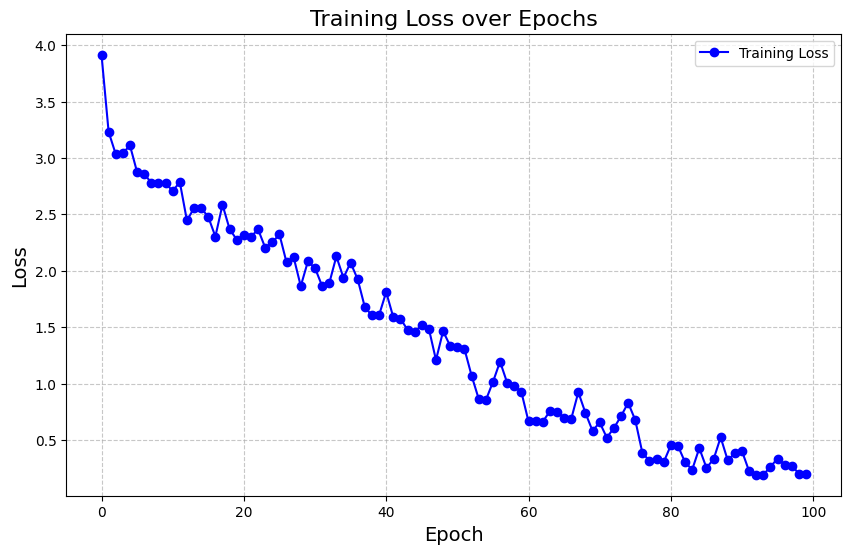

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [12]:
train_accuracy = calculate_accuracy(train_loader, model, device)
test_accuracy = calculate_accuracy(test_loader, model, device)

console.print(f"Train Accuracy: {train_accuracy:.2f}%")
console.print(f"Test Accuracy: {test_accuracy:.2f}%")

Train Accuracy: 98.91%

Test Accuracy: 21.74%

In [13]:
def save_model(model, optimizer, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    console.print(f"Model saved to {path}", style="bold green")
    
save_path = 'model.pth'
save_model(model, optimizer, save_path)

Model saved to model.pth

In [21]:
def load_model(path):
    model = models.resnet18(pretrained=False)
    num_classes = len(dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()
    console.print(f"Model loaded from {path}", style="bold green")
    return model

model = load_model(save_path)

/home/logo/miniconda3/envs/LoGo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded from model.pth

In [22]:
import random

In [23]:
def plot_images(images, labels, preds, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for img, lbl, pred, ax in zip(images, labels, preds, axes):
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Actual: {class_names[lbl]}\nPredicted: {class_names[pred]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

/home/logo/miniconda3/envs/LoGo/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.3328106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6116778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3328106].
Clipping input data to the valid range for imshow 

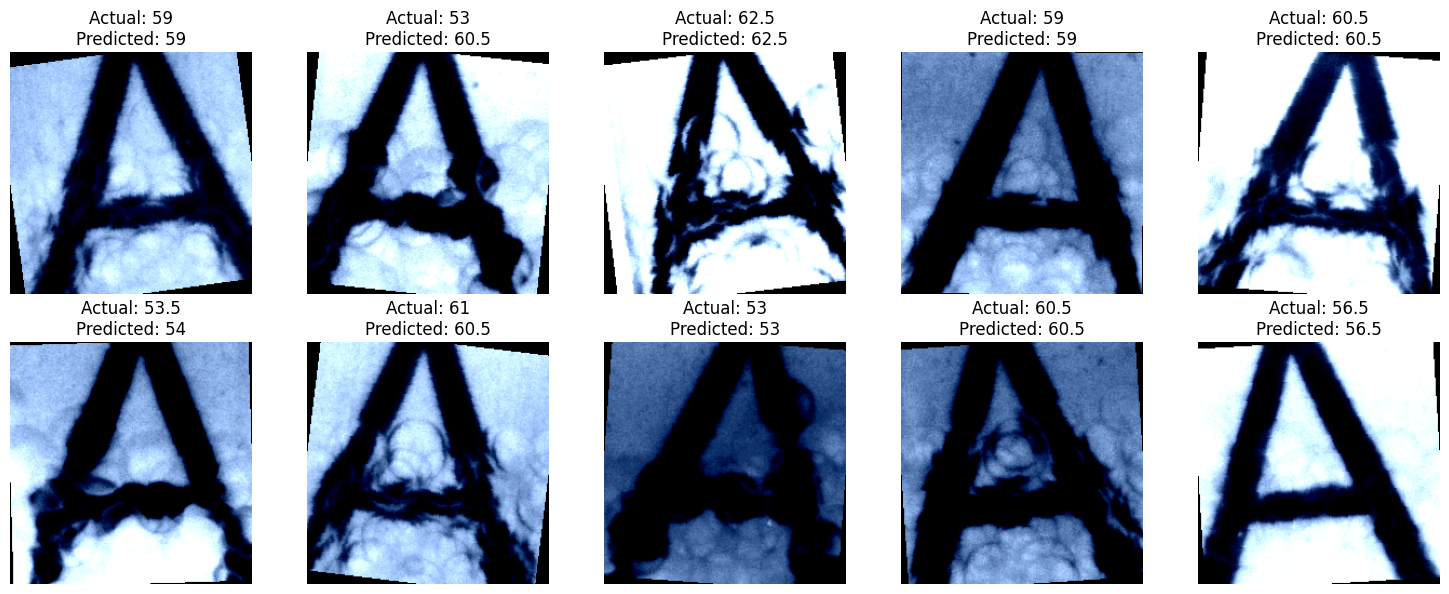

In [24]:
random_samples = random.sample(range(len(test_dataset)), 10)
images, labels = zip(*[test_dataset[i] for i in random_samples])

inputs = torch.stack(images).to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

plot_images(inputs, labels, preds.cpu().numpy(), dataset.classes)